In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import pearsonr, kendalltau, spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, fbeta_score

In [2]:
# file path
csv_file_path = "loan_default.csv"

# load file
df = pd.read_csv(csv_file_path, dtype={'MyColumn': 'str'})

In [12]:
df['term'].value_counts()

term
 36 months    2157
 60 months     693
Name: count, dtype: int64

In [3]:
def preprocess(df):
    # preprocessing
    # remove months from term column and convert numbers 36 and 60 to integers
    df['term'] = df['term'].str.extract('(\d+)').astype(int)

    # encode grade column
    grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

    # apply the mapping
    df['grade'] = df['grade'].map(grade_mapping)

    # encode emp_length column
    emp_length_mapping = {'< 1 year': 1, '1 year': 2, '2 years': 3, '3 years': 4, '4 years': 5, '5 years': 6,
                          '6 years': 7, '7 years': 8, '8 years': 9, '9 years': 10, '10+ years': 11}
    # apply the mapping
    df['emp_length'] = df['emp_length'].map(emp_length_mapping)

    # fill NaN values of emp_length column
    df['emp_length'].fillna(0, inplace=True)
    
    def fix_year(year):
        year = int(year)
        if year > 20:
            return year + 1900
        else:
            return year + 2000

    # Convert the string values to datetime objects
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'].apply(lambda x: x[:3] + '-'+ str(fix_year(x[4:]))), format='%b-%Y')

    # Specify the end date as December 2011
    end_date = pd.to_datetime('Dec-2011', format='%b-%Y')

    # Calculate the number of months between the dates and the end date
    df['earliest_cr_line'] = (end_date.year - df['earliest_cr_line'].dt.year) * 12 + (end_date.month - df['earliest_cr_line'].dt.month)

    # Use one-hot encoding for home_ownership, verification_status, purpose columns
    # supress warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Fit the encoder on the categorical column and transform it
    encoded_data = encoder.fit_transform(df[['home_ownership', 'verification_status', 'purpose']])

    # Create a new DataFrame with one-hot encoded columns
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['home_ownership', 'verification_status', 'purpose']))

    # remove irrelevant features
    df = df.drop(columns=['id'])

    # remove redundant categorical features
    df = df.drop(columns=['home_ownership', 'verification_status', 'purpose'])

    # extract lables from dataset and remove 'class' column
    labels = df['class'].values
    df = df.drop('class', axis=1)

    # concat encoded dataframe with original dataframe
    df1 = pd.concat([df, encoded_df], axis=1)
    data = pd.concat([df, encoded_df], axis=1).to_numpy()
    
    return data, labels, df1

In [4]:
data, labels, df1 = preprocess(df)

In [5]:
# split data into train and test 
trainx_b, testx_b, trainy, testy = train_test_split(data, labels, test_size=0.2, random_state=42)

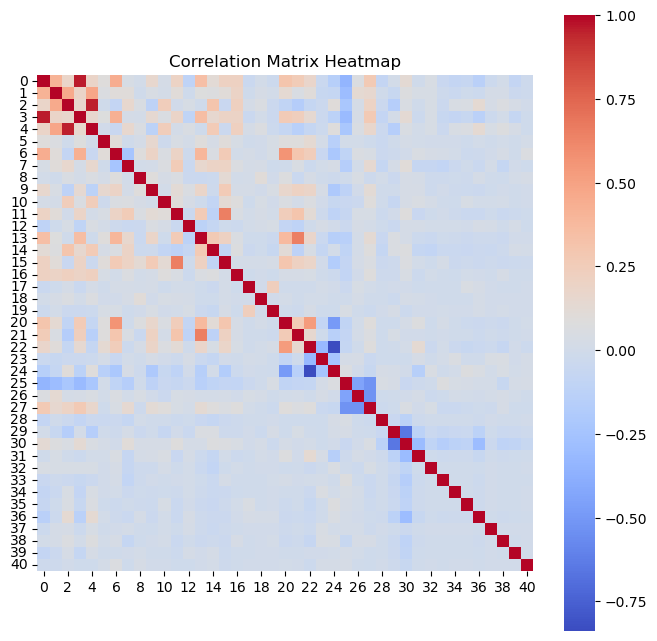

In [6]:
def compute_correlation(x, corrtype):
    # number of features
    n_features = x.shape[1]
    
    # create correlation matrix
    corr = np.zeros((n_features, n_features))
    
    if corrtype == 'pearson':
        for i in range(n_features):
            for j in range(n_features):
                corr[i, j], _ = pearsonr(x[:, i], x[:, j])
    elif corrtype == 'kendall':
        for i in range(n_features):
            for j in range(n_features):
                corr[i, j], _ = kendalltau(x[:, i], x[:, j])
    elif corrtype == 'spearman':
        for i in range(n_features):
            for j in range(n_features):
                corr[i, j], _ = spearmanr(x[:, i], x[:, j])
                
    return corr

# Pearson
corr = compute_correlation(trainx_b, 'pearson')
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [6]:
columns_to_remove = [0, 2, 6, 10, 12, 19, 21, 26, 28]

# Remove the specified columns
trainx_d = np.delete(trainx_b, columns_to_remove, axis=1)
testx_d = np.delete(testx_b, columns_to_remove, axis=1)

In [7]:
# rank correlation
# number of features
n_features = trainx_d.shape[1]

# create correlation vector
corr = np.zeros(n_features)

for i in range(n_features):
    corr[i], _ = pearsonr(trainx_d[:, i], trainy)

# calculate absolute values
# corr = abs(corr)
print(corr)

# We take k to be 25!

[ 0.15607183  0.01968187  0.26459172 -0.05273085  0.16757451  0.03439004
 -0.02759564 -0.0031393  -0.03208417  0.10968028 -0.04962906  0.44768437
 -0.0052745   0.02011764 -0.07174047 -0.04456662 -0.02987228  0.06270531
 -0.079648    0.07906505 -0.0102005   0.04017201 -0.0812016  -0.01747612
 -0.02104784  0.02746644 -0.01482373  0.01349266 -0.01931669  0.05493955
  0.00557885 -0.01006764]


In [8]:
def rank_correlation(x, y):
    # number of features
    n_features = x.shape[1]
    
    # create correlation vector
    corr = np.zeros(n_features)
    
    for i in range(n_features):
        corr[i], _ = pearsonr(x[:, i], y)
        
    # calculate absolute values
    corr = abs(corr)
    
    # find indices in descending order
    sorted_indices = np.argsort(corr)[::-1]
    
    return sorted_indices

# select features form rank correlation function
k = 25
selected_columns = rank_correlation(trainx_d, trainy)[:k]
trainx_d = trainx_d[:, selected_columns]
testx_d = testx_d[:, selected_columns]

In [9]:
def run_pca(train_x, test_x):
    # normaliztion
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    # Transform the testing data based on the fitted scaler
    test_x = scaler.transform(test_x)
    # PCA
    pca = PCA(n_components = 0.95)
    pca.fit(train_x)
    train_x = pca.transform(train_x)
    test_x = pca.transform(test_x)
    # number of PCs
    nPC = train_x.shape[1]
    # PCs
    PC = pca.components_
    return (nPC, PC, train_x, test_x)

(nPC, PC, trainx_h, testx_h) = run_pca(trainx_b, testx_b)

In [11]:
print('Number of PCs to capture 95% of the variance in data: ', nPC)
print('First 3 PCs are: ')
print('PC1: ', PC[1, :])
idx = np.argsort(-np.abs(PC[1, :]))
print('important indices are: ', idx[:5])
print(df1.columns[idx[:5]])
print('PC1: ', PC[2, :])
idx = np.argsort(-np.abs(PC[2, :]))
print('important indices are: ', idx[:5])
print(df1.columns[idx[:5]])
print('PC1: ', PC[3, :])
idx = np.argsort(-np.abs(PC[3, :]))
print('important indices are: ', idx[:5])
print(df1.columns[idx[:5]])

Number of PCs to capture 95% of the variance in data:  31
First 3 PCs are: 
PC1:  [-1.08801201e-01 -2.72489851e-01 -4.90656688e-01 -9.01816100e-02
 -4.82651863e-01  5.74225268e-02  1.52223694e-01 -1.37000078e-01
 -6.68733664e-04  1.35151035e-01 -1.09857488e-01  8.28695970e-02
 -2.94628595e-02  9.50686418e-02 -1.80695188e-01  1.19397168e-01
 -1.66533510e-01 -2.93434261e-04 -3.56439811e-02  4.25083375e-02
  1.91909937e-01  1.85575932e-01  1.95223997e-01  1.92761660e-02
 -2.10569352e-01  2.04692978e-01 -3.46225729e-02 -1.62276907e-01
  3.29621878e-02  1.14901314e-01 -9.68682519e-02  5.35769521e-02
 -2.62273448e-02  5.64959573e-02  2.35104118e-03 -3.23724419e-02
 -5.73064931e-02 -1.62469946e-02 -5.62635612e-02 -4.78954605e-03
  1.68040631e-02]
important indices are:  [ 2  4  1 24 25]
Index(['int_rate', 'grade', 'term', 'home_ownership_RENT',
       'verification_status_Not Verified'],
      dtype='object')
PC1:  [ 1.57775376e-01 -1.19794030e-01 -1.79993447e-01  1.90602223e-01
 -1.89315251e

In [10]:
def run_nmf(train_x, test_x, k):
    scaler = MinMaxScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)
    nmf = NMF(n_components=k, init='random')
    W_train = nmf.fit_transform(train_x)
    H = nmf.components_
    W_test = nmf.transform(test_x)
    train_x_reconstruct = np.dot(W_train, H)
    error = np.linalg.norm(train_x - train_x_reconstruct)
    return (error, H, W_train, W_test)

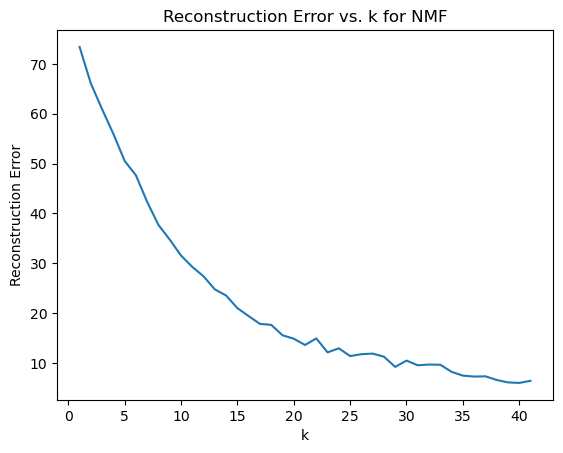

In [13]:
errors = []
for k in range(1, trainx_b.shape[1] + 1):
    (err, _, _, _) = run_nmf(trainx_b, testx_b, k)
    errors.append(err)
k = np.arange(1, trainx_b.shape[1] + 1)
plt.plot(k, errors)
plt.xlabel('k')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. k for NMF')
plt.show()

In [11]:
(error, H, trainx_k, testx_k) = run_nmf(trainx_b, testx_b, 30)

In [16]:
print('First 3 factors are: ')
print('F1: ', H[1, :])
idx = np.argsort(-np.abs(H[1, :]))
print('important indices are: ', idx[:5])
print(df1.columns[idx[:5]])

print('F2: ', H[2, :])
idx = np.argsort(-np.abs(H[2, :]))
print('important indices are: ', idx[:5])
print(df1.columns[idx[:5]])

print('F3: ', H[3, :])
idx = np.argsort(-np.abs(H[3, :]))
print('important indices are: ', idx[:5])
print(df1.columns[idx[:5]])

First 3 factors are: 
F1:  [0.00000000e+00 0.00000000e+00 1.19941895e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.53091603e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.06979320e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.03454888e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.08089317e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.33607760e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
important indices are:  [27  2 32 16  6]
Index(['verification_status_Verified', 'int_rate', 'purpose_house',
       'recoveries', 'annual_inc'],
      dtype='object')
F2:  [0.0520298  0.         0.00531637 0.0454755  0.         0.
 0.         0.05986972 0.         0.03866697 0.         0.05528227
 0.         0.01059228 0.         0.01456083 0. 

In [12]:
def build_logr(train_x, train_y, test_x, test_y):
    # split train into train and validation 
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
    # create lr model
    model = LogisticRegression()
    # train model
    model.fit(train_x, train_y)
    # predict
    train_y_pred = model.predict(train_x)
    val_y_pred = model.predict(val_x)
    test_y_pred = model.predict(test_x)
    # AUC
    train_auc = roc_auc_score(train_y, train_y_pred)
    val_auc = roc_auc_score(val_y, val_y_pred)
    test_auc = roc_auc_score(test_y, test_y_pred)
    # F1 score
    train_f1 = f1_score(train_y, train_y_pred)
    val_f1 = f1_score(val_y, val_y_pred)
    test_f1 = f1_score(test_y, test_y_pred)
    # F2 score
    train_f2 = fbeta_score(train_y, train_y_pred, beta=2)
    val_f2 = fbeta_score(val_y, val_y_pred, beta=2)
    test_f2 = fbeta_score(test_y, test_y_pred, beta=2)
    return {'train-auc': train_auc, 'train-f1': train_f1, 'train-f2': train_f2, 
            'val-auc': val_auc, 'val-f1': val_f1, 'val-f2': val_f2, 
            'test-auc': test_auc, 'test-f1': test_f1, 'test-f2': test_f2, 
            'params': {}}

In [18]:
print('Dataset b: ')
print(build_logr(trainx_b, trainy, testx_b, testy))

Dataset b: 
{'train-auc': 0.7270220588235294, 'train-f1': 0.6245259165613147, 'train-f2': 0.5096987205943045, 'val-auc': 0.6990808823529411, 'val-f1': 0.5699481865284974, 'val-f2': 0.45757071547420963, 'test-auc': 0.7369852941176471, 'test-f1': 0.6428571428571428, 'test-f2': 0.531496062992126, 'params': {}}


In [19]:
print('Dataset d: ')
print(build_logr(trainx_d, trainy, testx_d, testy))

Dataset d: 
{'train-auc': 0.7270220588235294, 'train-f1': 0.6245259165613147, 'train-f2': 0.5096987205943045, 'val-auc': 0.7022058823529411, 'val-f1': 0.5759162303664922, 'val-f2': 0.4590984974958264, 'test-auc': 0.7382352941176471, 'test-f1': 0.645418326693227, 'test-f2': 0.5321944809461235, 'params': {}}


In [20]:
print('Dataset h: ')
print(build_logr(trainx_h, trainy, testx_h, testy))

Dataset h: 
{'train-auc': 0.7344439338235295, 'train-f1': 0.6369119420989143, 'train-f2': 0.5363673303535149, 'val-auc': 0.6844669117647059, 'val-f1': 0.5427135678391959, 'val-f2': 0.44481054365733114, 'test-auc': 0.7257352941176471, 'test-f1': 0.6206896551724137, 'test-f2': 0.5252918287937743, 'params': {}}


In [21]:
print('Dataset k: ')
print(build_logr(trainx_k, trainy, testx_k, testy))

Dataset k: 
{'train-auc': 0.5572150735294118, 'train-f1': 0.2606232294617564, 'train-f2': 0.19674935842600516, 'val-auc': 0.5674632352941176, 'val-f1': 0.28888888888888886, 'val-f2': 0.22108843537414966, 'test-auc': 0.5326470588235294, 'test-f1': 0.20814479638009048, 'test-f2': 0.15731874145006838, 'params': {}}


In [13]:
def build_dt(train_x, train_y, test_x, test_y): 
    # Create a Decision Tree classifier
    model = DecisionTreeClassifier()

    # Define the hyperparameter grid to search
    n = 15
    param_grid = {
        'max_depth': list(np.arange(2, n+1)),  
        'min_samples_leaf': list(np.arange(2, n+1))  
    }
    
    # Create a custom scoring function
    scoring = {'auc': 'roc_auc', 'f1': 'f1', 'f2': make_scorer(fbeta_score, beta=2)}
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='auc', verbose=2,
                               return_train_score=True)
    
    # Perform grid search with cross-validation
    grid_search.fit(train_x, train_y)
    
    # predict on test data
    test_y_pred = grid_search.predict(test_x)
    
    # index pf best classifier in grid search
    idx = grid_search.best_index_
    
    # Get the best hyperparameters
    best_depth = grid_search.best_params_['max_depth']
    best_leaf_samples = grid_search.best_params_['min_samples_leaf']
    
    # AUC
    results = grid_search.cv_results_
    train_auc = results['mean_train_auc'][idx] 
    val_auc = results['mean_test_auc'][idx] 
    test_auc = roc_auc_score(test_y, test_y_pred) 
    # F1
    train_f1 = results['mean_train_f1'][idx] 
    val_f1 = results['mean_test_f1'][idx] 
    test_f1 = f1_score(test_y, test_y_pred) 
    # F2
    train_f2 = results['mean_train_f2'][idx] 
    val_f2 = results['mean_test_f2'][idx] 
    test_f2 = fbeta_score(test_y, test_y_pred, beta=2)
    
    return {'train-auc': train_auc, 'train-f1': train_f1, 'train-f2': train_f2, 
            'val-auc': val_auc, 'val-f1': val_f1, 'val-f2': val_f2, 
            'test-auc': test_auc, 'test-f1': test_f1, 'test-f2': test_f2, 
            'params': param_grid, 'best-depth':best_depth, 'best-leaf-samples':best_leaf_samples}

In [24]:
build_dt(trainx_b, trainy, testx_b, testy)

Fitting 5 folds for each of 196 candidates, totalling 980 fits
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=2, min_

[CV] END ....................max_depth=3, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=11; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=4; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=11; total time=   0.0s
[CV] END ...................

[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=3; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=10; total time=   0.0s
[CV] END ..................m

[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=4; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=4; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=11; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=11; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=11; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=11; total time=   0.0s
[CV] END ..................m

{'train-auc': 0.8195097081801471,
 'train-f1': 0.6164581975242911,
 'train-f2': 0.5019734575131858,
 'val-auc': 0.8148943014705882,
 'val-f1': 0.6151206181322657,
 'val-f2': 0.5006817963173394,
 'test-auc': 0.7382352941176471,
 'test-f1': 0.645418326693227,
 'test-f2': 0.5321944809461235,
 'params': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
 'best-depth': 3,
 'best-leaf-samples': 13}

In [25]:
build_dt(trainx_d, trainy, testx_d, testy)

Fitting 5 folds for each of 196 candidates, totalling 980 fits
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=2, min_

[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=12; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=12; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=12; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=12; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=12; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=13; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=5; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=7; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=6, min_samples_leaf=12; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=15; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=8, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=6; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=8; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=9, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=13; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=14; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=15; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=11, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=7; total time=   0.0s
[CV] END ...................

[CV] END ..................max_depth=12, min_samples_leaf=12; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=12; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=12; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=12; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=13; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=13; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=13; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=13; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=13; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=14; total time=   0.0s
[CV] END ..................m

[CV] END ...................max_depth=14, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=8; total time=   0.0s
[CV] END ...................

[CV] END ..................max_depth=15, min_samples_leaf=13; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=13; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=15; total time=   0.0s


{'train-auc': 0.8186443014705882,
 'train-f1': 0.6149802700362936,
 'train-f2': 0.49963803108658517,
 'val-auc': 0.8092715992647058,
 'val-f1': 0.613667704292193,
 'val-f2': 0.49917821148364583,
 'test-auc': 0.7382352941176471,
 'test-f1': 0.645418326693227,
 'test-f2': 0.5321944809461235,
 'params': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
 'best-depth': 3,
 'best-leaf-samples': 2}

In [26]:
build_dt(trainx_h, trainy, testx_h, testy)

Fitting 5 folds for each of 196 candidates, totalling 980 fits
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=2, min_

[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=4; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=11; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_leaf=11; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=7, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_leaf=15; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=9, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................

[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=3; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=12, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................

[CV] END ..................max_depth=13, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=15, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=6; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=7; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................

{'train-auc': 0.7965000287224264,
 'train-f1': 0.5236437675312573,
 'train-f2': 0.43205205732878893,
 'val-auc': 0.7027642463235295,
 'val-f1': 0.41569762486092554,
 'val-f2': 0.342945575415151,
 'test-auc': 0.5922794117647059,
 'test-f1': 0.3544303797468355,
 'test-f2': 0.28112449799196787,
 'params': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
 'best-depth': 5,
 'best-leaf-samples': 9}

In [27]:
build_dt(trainx_k, trainy, testx_k, testy)

Fitting 5 folds for each of 196 candidates, totalling 980 fits
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=4; total time=   0.0s
[CV] END ....................max_depth=2, min_

[CV] END ....................max_depth=3, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_leaf=11; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=4, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_leaf=15; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=5, min_samples_leaf=3; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=6, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=6, min_samples_leaf=9; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=7, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_leaf=15; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ....................max_depth=8, min_samples_leaf=3; total time=   0.0s
[CV] END ...................

[CV] END ....................max_depth=9, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=8; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=9, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................max_depth=9, min_samples_leaf=10; total time=   0.0s
[CV] END ...................

[CV] END ..................max_depth=10, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=14; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=10, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=11, min_samples_leaf=2; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=12, min_samples_leaf=9; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_leaf=10; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=13, min_samples_leaf=15; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_leaf=15; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=2; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................max_depth=14, min_samples_leaf=3; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=8; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=9; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_leaf=10; total time=   0.0s
[CV] END ..................m

{'train-auc': 0.8263400448069852,
 'train-f1': 0.6022804328997148,
 'train-f2': 0.5075541108097663,
 'val-auc': 0.7716842830882353,
 'val-f1': 0.5555356136841543,
 'val-f2': 0.4676115854255821,
 'test-auc': 0.7177941176470588,
 'test-f1': 0.6060606060606061,
 'test-f2': 0.5167958656330749,
 'params': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
 'best-depth': 4,
 'best-leaf-samples': 15}

In [14]:
def build_rf(train_x, train_y, test_x, test_y): 
    # Create a Decision Tree classifier
    model = RandomForestClassifier()

    # Define the hyperparameter grid to search
    n = 20
    param_grid = {
        'n_estimators': [20, 50, 100],
        'max_depth': list(np.arange(2, n+1)),  
        'min_samples_leaf': list(np.arange(2, n+1))  
    }
    
    # Create a custom scoring function
    scoring = {'auc': 'roc_auc', 'f1': 'f1', 'f2': make_scorer(fbeta_score, beta=2)}
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='auc', verbose=2,
                               return_train_score=True)
    
    # Perform grid search with cross-validation
    grid_search.fit(train_x, train_y)
    
    # predict on test data
    test_y_pred = grid_search.predict(test_x)
    
    # index pf best classifier in grid search
    idx = grid_search.best_index_
    
    # Get the best hyperparameters
    best_depth = grid_search.best_params_['max_depth']
    best_leaf_samples = grid_search.best_params_['min_samples_leaf']
    best_n_estimator = grid_search.best_params_['n_estimators']
    
    # AUC
    results = grid_search.cv_results_
    train_auc = results['mean_train_auc'][idx] 
    val_auc = results['mean_test_auc'][idx] 
    test_auc = roc_auc_score(test_y, test_y_pred) 
    # F1
    train_f1 = results['mean_train_f1'][idx] 
    val_f1 = results['mean_test_f1'][idx] 
    test_f1 = f1_score(test_y, test_y_pred) 
    # F2
    train_f2 = results['mean_train_f2'][idx] 
    val_f2 = results['mean_test_f2'][idx] 
    test_f2 = fbeta_score(test_y, test_y_pred, beta=2)
    
    return {'train-auc': train_auc, 'train-f1': train_f1, 'train-f2': train_f2, 
            'val-auc': val_auc, 'val-f1': val_f1, 'val-f2': val_f2, 
            'test-auc': test_auc, 'test-f1': test_f1, 'test-f2': test_f2, 
            'params': param_grid, 'best-depth':best_depth, 'best-leaf-samples':best_leaf_samples, 
            'best-n-estimator': best_n_estimator}

In [29]:
build_rf(trainx_b, trainy, testx_b, testy)

Fitting 5 folds for each of 1083 candidates, totalling 5415 fits
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=2, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=2, 

[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min

[CV] END ..max_depth=2, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min

[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_s

[CV] END .max_depth=3, min_samples_leaf=16, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.1s
[CV] END .max_depth=3, min_s

[CV] END ..max_depth=4, min_samples_leaf=4, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=4, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=4, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=4, n_estimators=100; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=4, min

[CV] END ..max_depth=4, min_samples_leaf=11, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=11, n_estimators=50; total time=   0.0s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.1s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.1s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.1s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.1s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_

[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=5, min_

[CV] END .max_depth=5, min_samples_leaf=12, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_s

[CV] END .max_depth=5, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_

[CV] END ...max_depth=6, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min

[CV] END ..max_depth=6, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_

[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_

[CV] END ..max_depth=7, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_

[CV] END .max_depth=7, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_

[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min

[CV] END ..max_depth=8, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=8, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=8, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_

[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=8, min_s

[CV] END ..max_depth=9, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=9, min_

[CV] END .max_depth=9, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END .max_depth=9, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END .max_depth=9, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_

[CV] END ..max_depth=9, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=9, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=9, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=9, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=9, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=9, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_

[CV] END ..max_depth=10, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=10, min

[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_s

[CV] END max_depth=10, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_s

[CV] END .max_depth=11, min_samples_leaf=7, n_estimators=100; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=7, n_estimators=100; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=7, n_estimators=100; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=7, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min

[CV] END .max_depth=11, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END max_depth=11, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_depth=11, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_depth=11, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_depth=11, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_depth=11, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=11, min_

[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min

[CV] END ..max_depth=12, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=9, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=12, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_

[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_s

[CV] END .max_depth=13, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END .max_depth=13, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_

[CV] END max_depth=13, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_

[CV] END .max_depth=13, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END max_depth=13, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_

[CV] END ..max_depth=14, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END .max_depth=14, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END .max_depth=14, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END .max_depth=14, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END .max_depth=14, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min

[CV] END .max_depth=14, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END .max_depth=14, min_

[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=14, min_s

[CV] END .max_depth=15, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END .max_depth=15, min_

[CV] END max_depth=15, min_samples_leaf=13, n_estimators=100; total time=   0.4s
[CV] END max_depth=15, min_samples_leaf=13, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, min_samples_leaf=13, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, min_samples_leaf=13, n_estimators=100; total time=   0.3s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_

[CV] END .max_depth=15, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=15, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min

[CV] END ..max_depth=16, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min

[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END max_depth=16, min_s

[CV] END .max_depth=17, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END .max_depth=17, min_

[CV] END .max_depth=17, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_

[CV] END .max_depth=17, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END max_depth=17, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END max_depth=17, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END max_depth=17, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END max_depth=17, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END max_depth=17, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_

[CV] END ..max_depth=18, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=18, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=18, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=18, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END .max_depth=18, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END .max_depth=18, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END .max_depth=18, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END .max_depth=18, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=18, min

[CV] END .max_depth=18, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.5s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.5s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END .max_depth=18, min_

[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END max_depth=18, min_s

[CV] END .max_depth=19, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=19, min_

[CV] END max_depth=19, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_

[CV] END .max_depth=19, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END max_depth=19, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_

[CV] END ..max_depth=20, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min

[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.3s
[CV] END .max_depth=20, min_

{'train-auc': 0.9019341681985296,
 'train-f1': 0.6238935285458836,
 'train-f2': 0.5092421342059492,
 'val-auc': 0.8352711397058824,
 'val-f1': 0.6105580812832966,
 'val-f2': 0.4972424226082575,
 'test-auc': 0.7382352941176471,
 'test-f1': 0.645418326693227,
 'test-f2': 0.5321944809461235,
 'params': {'n_estimators': [20, 50, 100],
  'max_depth': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20],
  'min_samples_leaf': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20]},
 'best-depth': 6,
 'best-leaf-samples': 11,
 'best-n-estimator': 100}

In [30]:
build_rf(trainx_d, trainy, testx_d, testy)

Fitting 5 folds for each of 1083 candidates, totalling 5415 fits
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=2, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=2, 

[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min

[CV] END ..max_depth=2, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min

[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_

[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=3, min_

[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=4, min_

[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.0s
[CV] END .max_depth=4, min_samples_leaf=12, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_s

[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, min

[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_

[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=6, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min

[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=6, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=6, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=6, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=6, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=6, min

[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=6, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=6, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=6, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=6, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=6, min_s

[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_

[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_

[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_

[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min

[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END .max_depth=8, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=8, min_

[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=8, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=8, min_s

[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=9, min_

[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_

[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.4s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=9, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_

[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.4s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=10, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=10, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=10, min

[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=14, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=14, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=14, n_estimators=100; total time=   0.4s
[CV] END .max_depth=10, min_

[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=11, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END .max_depth=11, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END .max_depth=11, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=11, min_

[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END .max_depth=11, min_

[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.9s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=20; total time=   0.1s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_

[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=12, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=12, min

[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=12, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=12, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=10, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_leaf=10, n_estimators=100; total time=   0.5s
[CV] END .max_depth=12, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_

[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END max_depth=12, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END max_depth=12, min_s

[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=5, n_estimators=100; total time=   1.1s
[CV] END .max_depth=13, min_

[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_

[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.4s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.2s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=13, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=13, min_

[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=14, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min

[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END max_depth=14, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_

[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=50; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=50; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=50; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=14, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=14, min_s

[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END .max_depth=15, min_

[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END .max_depth=15, min_

[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min

[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_

[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.1s
[CV] END max_depth=16, min_samples_leaf=16, n_estimators=100; total time=   0.2s
[CV] END max_depth=16, min_samples_leaf=16, n_estimators=100; total time=   0.2s
[CV] END max_depth=16, min_samples_leaf=16, n_estimators=100; total time=   0.2s
[CV] END max_depth=16, min_samples_leaf=16, n_estimators=100; total time=   0.2s
[CV] END max_depth=16, min_s

[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=4, n_estimators=100; total time=   0.3s
[CV] END .max_depth=17, min_

[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.2s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_

[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.0s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.2s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=17, min_

[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=18, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=18, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=18, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=18, min

[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_

[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.1s
[CV] END max_depth=18, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=19, n_estimators=100; total time=   0.2s
[CV] END max_depth=18, min_s

[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=7, n_estimators=100; total time=   0.3s
[CV] END .max_depth=19, min_

[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=50; total time=   0.1s
[CV] END .max_depth=19, min_

[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=20, min

[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=20, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min

[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_

{'train-auc': 0.9146946806066177,
 'train-f1': 0.6520730953560188,
 'train-f2': 0.5400321293978083,
 'val-auc': 0.8340762867647058,
 'val-f1': 0.6164591217723775,
 'val-f2': 0.5065748751133105,
 'test-auc': 0.7374264705882354,
 'test-f1': 0.6431372549019608,
 'test-f2': 0.5359477124183007,
 'params': {'n_estimators': [20, 50, 100],
  'max_depth': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20],
  'min_samples_leaf': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20]},
 'best-depth': 7,
 'best-leaf-samples': 8,
 'best-n-estimator': 20}

In [31]:
build_rf(trainx_h, trainy, testx_h, testy)

Fitting 5 folds for each of 1083 candidates, totalling 5415 fits
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=2, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=2, 

[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=2, min

[CV] END ..max_depth=2, min_samples_leaf=15, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.4s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.3s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min

[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=3, min_

[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_s

[CV] END ..max_depth=4, min_samples_leaf=4, n_estimators=100; total time=   0.5s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=4, min_

[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=4, min_

[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.6s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min

[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=5, min_

[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END .max_depth=5, min_s

[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=6, min_

[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.7s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=6, min_

[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.8s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=7, min

[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.9s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=7, min_

[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.3s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.7s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.7s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.7s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.7s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=7, min_

[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=8, min_

[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.7s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.7s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_

[CV] END ..max_depth=8, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.8s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.6s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.7s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.5s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.2s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=8, min_

[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min

[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.3s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=9, min_

[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_s

[CV] END .max_depth=10, min_samples_leaf=6, n_estimators=100; total time=   0.7s
[CV] END .max_depth=10, min_samples_leaf=6, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END .max_depth=10, min_

[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.3s
[CV] END .max_depth=10, min_

[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min

[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.8s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.7s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.7s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.8s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min

[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END .max_depth=11, min_

[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.8s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.9s
[CV] END .max_depth=12, min_

[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.7s
[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.8s
[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.7s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_

[CV] END .max_depth=12, min_samples_leaf=16, n_estimators=50; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.6s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.7s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.6s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.6s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.7s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_

[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.4s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.9s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.7s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=13, min

[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.7s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END .max_depth=13, min_

[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END max_depth=13, min_s

[CV] END .max_depth=14, min_samples_leaf=5, n_estimators=100; total time=   2.1s
[CV] END .max_depth=14, min_samples_leaf=5, n_estimators=100; total time=   1.8s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.2s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.2s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.2s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.2s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.2s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.8s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.7s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.6s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.5s
[CV] END .max_depth=14, min_

[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_

[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.6s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.1s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.1s
[CV] END .max_depth=14, min_

[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=15, min

[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.7s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END .max_depth=15, min_

[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.4s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   1.0s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   1.1s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   1.1s
[CV] END .max_depth=16, min_

[CV] END .max_depth=16, min_samples_leaf=8, n_estimators=100; total time=   0.6s
[CV] END .max_depth=16, min_samples_leaf=8, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END .max_depth=16, min_

[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.6s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=16, min_

[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.6s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=17, min_samples_leaf=3, n_estimators=50; total time=   0.5s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.9s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   1.0s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.9s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.9s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min

[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.8s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_

[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_s

[CV] END .max_depth=18, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END .max_depth=18, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END .max_depth=18, min_

[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.7s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.8s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.7s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.7s
[CV] END max_depth=18, min_samples_leaf=11, n_estimators=100; total time=   0.8s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_

[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=18, n_estimators=50; total time=   0.3s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.6s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.7s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.8s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.6s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.6s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_

[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=19, min_samples_leaf=6, n_estimators=50; total time=   0.4s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.8s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.7s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   1.0s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.7s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.9s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=19, min

[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.3s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.3s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.3s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.7s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.7s
[CV] END max_depth=19, min_s

[CV] END max_depth=19, min_samples_leaf=19, n_estimators=100; total time=   0.6s
[CV] END max_depth=19, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END max_depth=19, min_s

[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.8s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.8s
[CV] END .max_depth=20, min_samples_leaf=7, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=20, min

[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.3s
[CV] END .max_depth=20, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_

{'train-auc': 0.88560546875,
 'train-f1': 0.4285283130659791,
 'train-f2': 0.321298776089429,
 'val-auc': 0.7717003676470588,
 'val-f1': 0.3653202455524355,
 'val-f2': 0.26825794616873433,
 'test-auc': 0.6016911764705882,
 'test-f1': 0.3398058252427184,
 'test-f2': 0.24441340782122903,
 'params': {'n_estimators': [20, 50, 100],
  'max_depth': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20],
  'min_samples_leaf': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20]},
 'best-depth': 6,
 'best-leaf-samples': 20,
 'best-n-estimator': 50}

In [32]:
build_rf(trainx_k, trainy, testx_k, testy)

Fitting 5 folds for each of 1083 candidates, totalling 5415 fits
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=2, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=2, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=2, 

[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=2, min_samples_leaf=8, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min_samples_leaf=9, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=2, min

[CV] END ..max_depth=2, min_samples_leaf=15, n_estimators=50; total time=   0.0s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.1s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END .max_depth=2, min_samples_leaf=15, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_leaf=16, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=2, min_

[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=3, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=3, min

[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_

[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=3, min_samples_leaf=17, n_estimators=50; total time=   0.1s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_leaf=17, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_s

[CV] END ..max_depth=4, min_samples_leaf=4, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=4, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=4, min_

[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.4s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END .max_depth=4, min_samples_leaf=11, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=12, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_

[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=4, min_samples_leaf=18, n_estimators=50; total time=   0.1s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END .max_depth=4, min_samples_leaf=18, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=4, min_

[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=7, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=5, min

[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.4s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.4s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.4s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.4s
[CV] END .max_depth=5, min_samples_leaf=13, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_

[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.4s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.4s
[CV] END .max_depth=5, min_samples_leaf=20, n_estimators=100; total time=   0.4s
[CV] END .max_depth=5, min_s

[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=6, min_samples_leaf=7, n_estimators=100; total time=   0.5s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=6, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=6, min_

[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.6s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END .max_depth=6, min_samples_leaf=14, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=6, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=6, min_

[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=7, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=7, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=7, min

[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=7, min_samples_leaf=9, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=7, min_samples_leaf=9, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_

[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=7, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.6s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END .max_depth=7, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=7, min_

[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=8, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=8, min_samples_leaf=4, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=8, min_

[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END .max_depth=8, min_samples_leaf=10, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=8, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END .max_depth=8, min_s

[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.5s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.5s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.5s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.5s
[CV] END .max_depth=8, min_samples_leaf=17, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=8, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=8, min_

[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=9, min_samples_leaf=5, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.8s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=9, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ...max_depth=9, min_samples_leaf=6, n_estimators=20; total time=   0.1s
[CV] END ...max_depth=9, min

[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=12, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_

[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=9, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=9, min_

[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END .max_depth=10, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END .max_depth=10, min_

[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=13, n_estimators=100; total time=   0.6s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=20; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_s

[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=20, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=11, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=11, min

[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=11, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.7s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.7s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.8s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.8s
[CV] END .max_depth=11, min_samples_leaf=8, n_estimators=100; total time=   0.9s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=11, min

[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=11, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=11, min_

[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=12, min_samples_leaf=3, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.8s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.8s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END .max_depth=12, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END .max_depth=12, min_

[CV] END .max_depth=12, min_samples_leaf=9, n_estimators=100; total time=   0.6s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=12, min_samples_leaf=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=12, min_s

[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END max_depth=12, min_samples_leaf=16, n_estimators=100; total time=   0.5s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=20; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_samples_leaf=17, n_estimators=50; total time=   0.2s
[CV] END .max_depth=12, min_

[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=13, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.7s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.7s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.7s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.7s
[CV] END .max_depth=13, min_samples_leaf=4, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=13, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=13, min

[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=11, n_estimators=50; total time=   0.2s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.5s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END max_depth=13, min_samples_leaf=11, n_estimators=100; total time=   0.6s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_

[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=20; total time=   0.0s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END .max_depth=13, min_samples_leaf=18, n_estimators=50; total time=   0.2s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.6s
[CV] END max_depth=13, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END .max_depth=13, min_

[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=14, min_samples_leaf=6, n_estimators=50; total time=   0.3s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.6s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.7s
[CV] END .max_depth=14, min_samples_leaf=6, n_estimators=100; total time=   0.6s
[CV] END .max_depth=14, min_

[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=12, n_estimators=100; total time=   0.5s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=13, n_estimators=50; total time=   0.2s
[CV] END max_depth=14, min_s

[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END max_depth=14, min_samples_leaf=19, n_estimators=100; total time=   0.5s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=20; total time=   0.0s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=14, min_

[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=15, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.6s
[CV] END .max_depth=15, min_samples_leaf=7, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=15, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=15, min

[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END .max_depth=15, min_samples_leaf=14, n_estimators=50; total time=   0.2s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END max_depth=15, min_samples_leaf=14, n_estimators=100; total time=   0.5s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=15, min_

[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=2, n_estimators=50; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.8s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END .max_depth=16, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=16, min

[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=16, min_samples_leaf=9, n_estimators=50; total time=   0.3s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.7s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.6s
[CV] END .max_depth=16, min_samples_leaf=9, n_estimators=100; total time=   0.6s
[CV] END .max_depth=16, min_

[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=16, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=20; total time=   0.0s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END .max_depth=16, min_samples_leaf=16, n_estimators=50; total time=   0.2s
[CV] END max_depth=16, min_s

[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END .max_depth=17, min_samples_leaf=3, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=17, min_samples_leaf=4, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=17, min

[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=10, n_estimators=100; total time=   0.6s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=11, n_estimators=20; total time=   0.0s
[CV] END .max_depth=17, min_

[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.3s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.2s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.2s
[CV] END .max_depth=17, min_samples_leaf=17, n_estimators=50; total time=   0.2s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.7s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.7s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, min_samples_leaf=17, n_estimators=100; total time=   0.6s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_samples_leaf=18, n_estimators=20; total time=   0.1s
[CV] END .max_depth=17, min_

[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=18, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.8s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.8s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.8s
[CV] END .max_depth=18, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=18, min

[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=12, n_estimators=50; total time=   0.2s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=18, min_samples_leaf=12, n_estimators=100; total time=   0.5s
[CV] END max_depth=18, min_s

[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END max_depth=18, min_samples_leaf=18, n_estimators=100; total time=   0.5s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.0s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.1s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=20; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.4s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.3s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END .max_depth=18, min_samples_leaf=19, n_estimators=50; total time=   0.2s
[CV] END max_depth=18, min_s

[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   1.0s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   1.0s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.8s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.7s
[CV] END .max_depth=19, min_samples_leaf=6, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=19, min_samples_leaf=7, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=19, min

[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.3s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.3s
[CV] END .max_depth=19, min_samples_leaf=13, n_estimators=50; total time=   0.3s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.8s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.7s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.5s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.7s
[CV] END max_depth=19, min_samples_leaf=13, n_estimators=100; total time=   0.8s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.1s
[CV] END .max_depth=19, min_samples_leaf=14, n_estimators=20; total time=   0.1s
[CV] END .max_depth=19, min_

[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END .max_depth=19, min_samples_leaf=20, n_estimators=50; total time=   0.2s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=19, min_samples_leaf=20, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=2, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=20, min

[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.1s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=20, min_samples_leaf=8, n_estimators=50; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.6s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.6s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.6s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.6s
[CV] END .max_depth=20, min_samples_leaf=8, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=20, min

[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=20; total time=   0.0s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END .max_depth=20, min_samples_leaf=15, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_s

{'train-auc': 0.9616432100183824,
 'train-f1': 0.6945218174466341,
 'train-f2': 0.5904017023938836,
 'val-auc': 0.8018658088235295,
 'val-f1': 0.573072437421699,
 'val-f2': 0.4769753482200981,
 'test-auc': 0.7093382352941177,
 'test-f1': 0.5905511811023622,
 'test-f2': 0.49083769633507857,
 'params': {'n_estimators': [20, 50, 100],
  'max_depth': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20],
  'min_samples_leaf': [2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20]},
 'best-depth': 10,
 'best-leaf-samples': 10,
 'best-n-estimator': 100}

In [15]:
# normaliztion
scaler = StandardScaler()
trainx_b_n = scaler.fit_transform(trainx_b)
# Transform the testing data based on the fitted scaler
testx_b_n = scaler.transform(testx_b)

# normaliztion
scaler = StandardScaler()
trainx_d_n = scaler.fit_transform(trainx_d)
# Transform the testing data based on the fitted scaler
testx_d_n = scaler.transform(testx_d)

In [16]:
def build_svm(train_x, train_y, test_x, test_y): 
    # Create a Decision Tree classifier
    model = SVC()

    # Define the hyperparameter grid to search
    param_grid = {'C': [0.01, 0.1, 1, 2],
                  'gamma': [0.01, 0.1, 1],
                  'kernel': ['linear', 'poly'],
                  'degree': [2, 3]}
    
    # Create a custom scoring function
    scoring = {'auc': 'roc_auc', 'f1': 'f1', 'f2': make_scorer(fbeta_score, beta=2)}
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='auc', verbose=2,
                               return_train_score=True)
    
    # Perform grid search with cross-validation
    grid_search.fit(train_x, train_y)
    
    # predict on test data
    test_y_pred = grid_search.predict(test_x)
    
    # index pf best classifier in grid search
    idx = grid_search.best_index_
    
    # Get the best hyperparameters
    best_C = grid_search.best_params_['C']
    best_gamma = grid_search.best_params_['gamma']
    best_kernel = grid_search.best_params_['kernel']
    best_degree = grid_search.best_params_['degree']
    
    # AUC
    results = grid_search.cv_results_
    train_auc = results['mean_train_auc'][idx] 
    val_auc = results['mean_test_auc'][idx] 
    test_auc = roc_auc_score(test_y, test_y_pred) 
    # F1
    train_f1 = results['mean_train_f1'][idx] 
    val_f1 = results['mean_test_f1'][idx] 
    test_f1 = f1_score(test_y, test_y_pred) 
    # F2
    train_f2 = results['mean_train_f2'][idx] 
    val_f2 = results['mean_test_f2'][idx] 
    test_f2 = fbeta_score(test_y, test_y_pred, beta=2)
    
    return {'train-auc': train_auc, 'train-f1': train_f1, 'train-f2': train_f2, 
            'val-auc': val_auc, 'val-f1': val_f1, 'val-f2': val_f2, 
            'test-auc': test_auc, 'test-f1': test_f1, 'test-f2': test_f2, 
            'params': param_grid, 'best-C':best_C, 'best-gamma':best_gamma,
            'best-kernel': best_kernel, 'best-degree': best_degree}

In [24]:
build_svm(trainx_b_n, trainy, testx_b_n, testy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, 

[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, 

[CV] END ..............C=2, degree=2, gamma=1, kernel=linear; total time=   0.1s
[CV] END ..............C=2, degree=2, gamma=1, kernel=linear; total time=   0.1s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  40.0s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  27.9s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  38.0s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  43.8s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  29.6s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.3s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END .............C=2, d

{'train-auc': 0.7705417049632353,
 'train-f1': 0.500475104181168,
 'train-f2': 0.3851152836978641,
 'val-auc': 0.7641498161764705,
 'val-f1': 0.4993536647058502,
 'val-f2': 0.38478511930653136,
 'test-auc': 0.6794117647058824,
 'test-f1': 0.5281385281385281,
 'test-f2': 0.41160593792172745,
 'params': {'C': [0.01, 0.1, 1, 2],
  'gamma': [0.01, 0.1, 1],
  'kernel': ['linear', 'poly'],
  'degree': [2, 3]},
 'best-C': 0.01,
 'best-gamma': 0.01,
 'best-kernel': 'linear',
 'best-degree': 2}

In [15]:
build_svm(trainx_d_n, trainy, testx_d_n, testy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, 

[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, 

[CV] END ..............C=2, degree=2, gamma=1, kernel=linear; total time=   0.3s
[CV] END ..............C=2, degree=2, gamma=1, kernel=linear; total time=   0.3s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time= 1.1min
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  34.9s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  41.3s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  47.7s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  41.0s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.3s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END .............C=2, d

{'train-auc': 0.876605583639706,
 'train-f1': 0.012383604430528782,
 'train-f2': 0.007794173237225638,
 'val-auc': 0.7760431985294117,
 'val-f1': 0.005776850886339937,
 'val-f2': 0.003659679903569276,
 'test-auc': 0.5058823529411764,
 'test-f1': 0.023255813953488372,
 'test-f2': 0.014662756598240468,
 'params': {'C': [0.01, 0.1, 1, 2],
  'gamma': [0.01, 0.1, 1],
  'kernel': ['linear', 'poly'],
  'degree': [2, 3]},
 'best-C': 0.1,
 'best-gamma': 0.01,
 'best-kernel': 'poly',
 'best-degree': 3}

In [26]:
build_svm(trainx_h, trainy, testx_h, testy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........C=0.01, degree=2, gamma=0.1, 

[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, 

[CV] END ..............C=2, degree=2, gamma=1, kernel=linear; total time=   0.5s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  25.6s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  25.3s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  18.0s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  35.3s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=  29.4s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.6s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.7s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.6s
[CV] END .............C=2, degree=3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .............C=2, d

{'train-auc': 0.8095166015625,
 'train-f1': 0.49532189822533157,
 'train-f2': 0.3803686240394213,
 'val-auc': 0.7990900735294117,
 'val-f1': 0.4942163326608373,
 'val-f2': 0.3800393101849536,
 'test-auc': 0.6794117647058824,
 'test-f1': 0.5281385281385281,
 'test-f2': 0.41160593792172745,
 'params': {'C': [0.01, 0.1, 1, 2],
  'gamma': [0.01, 0.1, 1],
  'kernel': ['linear', 'poly'],
  'degree': [2, 3]},
 'best-C': 0.01,
 'best-gamma': 0.01,
 'best-kernel': 'linear',
 'best-degree': 2}

In [16]:
build_svm(trainx_k, trainy, testx_k, testy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ........C=0.01, degree=2, gamma=0.01, kernel=linear; total time=   0.3s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.2s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.2s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.2s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.2s
[CV] END ..........C=0.01, degree=2, gamma=0.01, kernel=poly; total time=   0.2s
[CV] END .........C=0.01, degree=2, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END .........C=0.01, degree=2, gamma=0.1, 

[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ..........C=0.1, degree=3, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=3, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.3s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.2s
[CV] END ............C=0.1, degree=3, gamma=1, kernel=linear; total time=   0.2s
[CV] END ............C=0.1, 

[CV] END ..............C=2, degree=2, gamma=1, kernel=linear; total time=   0.4s
[CV] END ..............C=2, degree=2, gamma=1, kernel=linear; total time=   0.4s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=   0.4s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=   0.6s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=   0.5s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=   0.4s
[CV] END ................C=2, degree=2, gamma=1, kernel=poly; total time=   0.4s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.4s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.4s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.4s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END ...........C=2, degree=3, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END .............C=2, d

{'train-auc': 0.8021556181066176,
 'train-f1': 0.09583154627379967,
 'train-f2': 0.06216380171830386,
 'val-auc': 0.7937132352941176,
 'val-f1': 0.09760669656072385,
 'val-f2': 0.06346894508147728,
 'test-auc': 0.5470588235294118,
 'test-f1': 0.17204301075268816,
 'test-f2': 0.1149425287356322,
 'params': {'C': [0.01, 0.1, 1, 2],
  'gamma': [0.01, 0.1, 1],
  'kernel': ['linear', 'poly'],
  'degree': [2, 3]},
 'best-C': 0.1,
 'best-gamma': 0.01,
 'best-kernel': 'linear',
 'best-degree': 2}

In [17]:
def build_nn(train_x, train_y, test_x, test_y): 
    # Create a Decision Tree classifier
    model = MLPClassifier(max_iter=100, solver='adam', learning_rate='adaptive')

    # Define the hyperparameter grid to search
    param_grid = {
        'hidden_layer_sizes': [(10, 30, 10), (100, 50), (40, 20), (20, ), (40, )],  
        'activation': ['relu', 'logistic', 'tanh'], 
        'alpha': [0.001, 0.01, 0.1, 1, 10], 
    }
    
    # Create a custom scoring function
    scoring = {'auc': 'roc_auc', 'f1': 'f1', 'f2': make_scorer(fbeta_score, beta=2)}
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='auc', verbose=2,
                               return_train_score=True)
    
    # Perform grid search with cross-validation
    grid_search.fit(train_x, train_y)
    
    # predict on test data
    test_y_pred = grid_search.predict(test_x)
    
    # index pf best classifier in grid search
    idx = grid_search.best_index_
    
    # Get the best hyperparameters
    best_hidden = grid_search.best_params_['hidden_layer_sizes']
    best_activation = grid_search.best_params_['activation']
    best_alpha = grid_search.best_params_['alpha']
    
    # AUC
    results = grid_search.cv_results_
    train_auc = results['mean_train_auc'][idx] 
    val_auc = results['mean_test_auc'][idx] 
    test_auc = roc_auc_score(test_y, test_y_pred) 
    # F1
    train_f1 = results['mean_train_f1'][idx] 
    val_f1 = results['mean_test_f1'][idx] 
    test_f1 = f1_score(test_y, test_y_pred) 
    # F2
    train_f2 = results['mean_train_f2'][idx] 
    val_f2 = results['mean_test_f2'][idx] 
    test_f2 = fbeta_score(test_y, test_y_pred, beta=2)
    
    return {'train-auc': train_auc, 'train-f1': train_f1, 'train-f2': train_f2, 
            'val-auc': val_auc, 'val-f1': val_f1, 'val-f2': val_f2, 
            'test-auc': test_auc, 'test-f1': test_f1, 'test-f2': test_f2, 
            'params': param_grid, 'best-hidden': best_hidden,
            'best-activation': best_activation, 'best-alpha': best_alpha}

In [20]:
build_nn(trainx_b_n, trainy, testx_b_n, testy)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidd

[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.6s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.6s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.7s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.7s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.9s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.9s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.9s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.9s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.9s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   1.1s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   1.3s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); 

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40, 20); total time=   0.7s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.6s
[CV] END activation=logistic, alpha=1, hidden_layer

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); 

{'train-auc': 0.8394117647058824,
 'train-f1': 0.6091538299380017,
 'train-f2': 0.5117197167789381,
 'val-auc': 0.8165716911764707,
 'val-f1': 0.5844085548631442,
 'val-f2': 0.4890414830505489,
 'test-auc': 0.7299264705882353,
 'test-f1': 0.628352490421456,
 'test-f2': 0.5317769130998703,
 'params': {'hidden_layer_sizes': [(10, 30, 10),
   (100, 50),
   (40, 20),
   (20,),
   (40,)],
  'activation': ['relu', 'logistic', 'tanh'],
  'alpha': [0.001, 0.01, 0.1, 1, 10]},
 'best-hidden': (100, 50),
 'best-activation': 'logistic',
 'best-alpha': 0.1}

In [21]:
build_nn(trainx_d_n, trainy, testx_d_n, testy)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   1.3s
[CV] END activation=relu, alpha=0.001, hidd

[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.5s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.5s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.4s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   0.4s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.7s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.8s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.7s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.6s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   0.7s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   1.1s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   1.0s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); 

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40, 20); total time=   1.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.7s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   0.6s
[CV] END activation=logistic, alpha=1, hidden_layer

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); 

{'train-auc': 0.837867359834559,
 'train-f1': 0.6149303443349136,
 'train-f2': 0.5177203546957643,
 'val-auc': 0.8221875000000001,
 'val-f1': 0.5992182814037763,
 'val-f2': 0.5018112041496576,
 'test-auc': 0.7329411764705882,
 'test-f1': 0.6323529411764706,
 'test-f2': 0.5498721227621484,
 'params': {'hidden_layer_sizes': [(10, 30, 10),
   (100, 50),
   (40, 20),
   (20,),
   (40,)],
  'activation': ['relu', 'logistic', 'tanh'],
  'alpha': [0.001, 0.01, 0.1, 1, 10]},
 'best-hidden': (100, 50),
 'best-activation': 'logistic',
 'best-alpha': 0.01}

In [18]:
build_nn(trainx_h, trainy, testx_h, testy)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidd

[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.1s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.1s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.8s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.9s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.5s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.6s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   1.8s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   2.4s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); 

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40, 20); total time=   1.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END activation=logistic, alpha=1, hidden_layer

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   2.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   2.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   1.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); 

{'train-auc': 0.8439122817095589,
 'train-f1': 0.6213047017553899,
 'train-f2': 0.5214071726732117,
 'val-auc': 0.8207766544117646,
 'val-f1': 0.5991357858169585,
 'val-f2': 0.5007573675131807,
 'test-auc': 0.7261764705882352,
 'test-f1': 0.6212121212121212,
 'test-f2': 0.5297157622739018,
 'params': {'hidden_layer_sizes': [(10, 30, 10),
   (100, 50),
   (40, 20),
   (20,),
   (40,)],
  'activation': ['relu', 'logistic', 'tanh'],
  'alpha': [0.001, 0.01, 0.1, 1, 10]},
 'best-hidden': (100, 50),
 'best-activation': 'logistic',
 'best-alpha': 0.001}

In [19]:
build_nn(trainx_k, trainy, testx_k, testy)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(10, 30, 10); total time=   1.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50); total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidd

[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.1s
[CV] END .activation=relu, alpha=1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.6s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.6s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.5s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.6s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(10, 30, 10); total time=   1.7s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   2.2s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); total time=   2.0s
[CV] END activation=relu, alpha=10, hidden_layer_sizes=(100, 50); 

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40, 20); total time=   0.8s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   1.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(40,); total time=   1.2s
[CV] END activation=logistic, alpha=1, hidden_layer

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   2.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50); total time=   2.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(40, 20); total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   1.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(20,); 

{'train-auc': 0.8284400850183824,
 'train-f1': 0.5969189843368679,
 'train-f2': 0.49359715985477887,
 'val-auc': 0.8118750000000002,
 'val-f1': 0.5780658076138007,
 'val-f2': 0.4762756258994013,
 'test-auc': 0.7235294117647059,
 'test-f1': 0.6178861788617886,
 'test-f2': 0.5026455026455027,
 'params': {'hidden_layer_sizes': [(10, 30, 10),
   (100, 50),
   (40, 20),
   (20,),
   (40,)],
  'activation': ['relu', 'logistic', 'tanh'],
  'alpha': [0.001, 0.01, 0.1, 1, 10]},
 'best-hidden': (100, 50),
 'best-activation': 'tanh',
 'best-alpha': 0.01}

In [28]:
# model = LogisticRegression()
# model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)
# model = RandomForestClassifier(max_depth=7, min_samples_leaf=8, n_estimators=20)
# model = SVC(C=0.01, gamma=0.01, kernel='linear')
model = MLPClassifier(max_iter=100, solver='adam', learning_rate='adaptive',
                      activation='logistic', hidden_layer_sizes=(100, 50), alpha=0.01)

In [29]:
start = time.time()
model.fit(trainx_d_n, trainy)
model.predict(testx_d_n)
print(time.time() - start)


1.5911633968353271
